In [110]:
import torch
import wandb
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

%matplotlib inline

# CIFAR-10: Image Classification

## 1. Data

In [24]:
root: str = "data/cifar10/train"

train_dataset = CIFAR10(
    root=root, 
    train=True, 
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    download=True,
)
val_dataset = CIFAR10(
    root=root, 
    train=False, 
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    download=True,
)

In [63]:
train_cls_counts = np.bincount(train_dataset.targets)
val_cls_counts = np.bincount(val_dataset.targets)

print(f"Train: {train_cls_counts}")
print(f"Val: {val_cls_counts}")

Train: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Val: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Class: deer


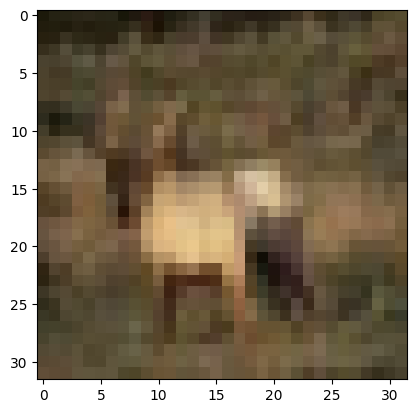

In [39]:
idx = 3

img, cls_idx = train_dataset[idx]

cls_label = train_dataset.classes[cls_idx]
print(f"Class: {cls_label}")
plt.imshow(img.permute(1,2,0));

## 2. Model

In [91]:
class ImageClassifier(nn.Module):
    def __init__(self, in_channels: int = 3, num_classes: int = 10):
        super().__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, self.num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)     # (B, 128, H', W')
        x = self.gap(x)          # (B, 128, 1, 1)
        x = x.flatten(1)         # (B, 128)
        x = self.classifier(x)   # (B, num_classes)
        return x


In [92]:
model = ImageClassifier(in_channels=3, num_classes=10)

In [93]:
out = model(batch[0])
out.shape

torch.Size([16, 10])

## 3. Training

In [130]:
num_epochs: int = 10
learning_rate: float = 1e-3
batch_size: int = 64
num_grad_accum_steps: int = 4

In [131]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [132]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [126]:
# Start a new wandb run to track this script
run = wandb.init(
    entity="willfurtado",
    project="cifar10",
    config={
        "learning_rate": learning_rate,
        "architecture": model.__class__.__name__,
        "dataset": dataset.__class__.__name__,
        "epochs": num_epochs,
    },
)

In [135]:
def run_training_loop():
    model.train()
    for step, (img, labels) in enumerate(tqdm(train_dataloader, desc="Train Batches")):
        logits = model(img)

        loss = loss_fn(logits, labels)
        scaled_loss = loss / num_grad_accum_steps # Scale loss by accum steps
        scaled_loss.backward()

        # Gradient accumulation to increase effective batch size
        # Check if we are on the last step of the dataloader --> force optimizer step
        if (step + 1) % num_grad_accum_steps == 0 or (step + 1) == len(train_dataloader):
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        run.log({"Loss/train_loss": loss.detach().item() * num_grad_accum_steps})

def run_validation_loop():
    model.eval()
    all_val_losses = []
    with torch.inference_mode():
        for img, labels in tqdm(val_dataloader, desc="Val Batches"):
            logits = model(img)
            loss = loss_fn(logits, labels)
            all_val_losses.append(loss.detach().item())
    
    run.log({"Loss/val_loss": np.mean(all_val_losses)})

In [136]:
for epoch in trange(num_epochs):
    run_training_loop()
    run_validation_loop()

  0%|          | 0/10 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Val Batches:   0%|          | 0/157 [00:00<?, ?it/s]